In [78]:
import pandas as pd 
import numpy as np 
from textblob import TextBlob
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import json, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

from sentiment_analysis_spanish import sentiment_analysis
import nltk
import pyLDAvis.gensim_models

import random
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [79]:
#df = pd.read_excel('Resultados Touchpoint APP Personas del 1abr al 24 May.xlsx')
#df = pd.read_excel('Touchpoint APP Personas 1 May al 8 Ago Prepago.xlsx')
df = pd.read_excel('Touchpoint APP Personas_ 1 al 31 ago completa.xlsx',sheet_name='SheetAjustado_2')
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
0,Fecha de inicio,Fecha de finalización,Tipo de respuesta,Dirección IP,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-08-01 00:02:16,2021-08-01 00:03:15,0,191.156.136.74,100,59,1,2021-08-01 00:03:16.244000,R_1IoVtduLafA89nU,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
len(df)

14610

In [81]:
df = df.drop([0], axis=0)
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-08-01 00:02:16,2021-08-01 00:03:15,0,191.156.136.74,100,59,1,2021-08-01 00:03:16.244000,R_1IoVtduLafA89nU,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-01 00:03:40,2021-08-01 00:06:10,0,191.156.38.37,100,150,1,2021-08-01 00:06:11.288000,R_1EcfZSS3c60c0mV,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df.Q2_NPS_GROUP.value_counts()

Promotor     6658
Detractor    2636
Pasivo       2136
Name: Q2_NPS_GROUP, dtype: int64

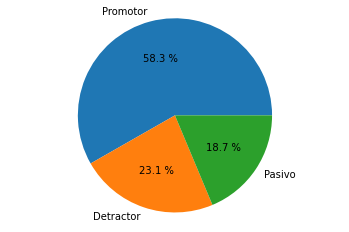

In [83]:
A = df.Q2_NPS_GROUP.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

####  Funciones para Limpieza de texto

In [84]:
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminamos comas y /
    texto = re.sub(r',', ' ', str(texto))
    texto = re.sub(r'/', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [85]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("spanish"))
def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CristhianJohnatanIzq\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
stemmer = SnowballStemmer("spanish")
def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

In [87]:
def Limpiar_Caracter(texto):
    if len(texto) == 1 or texto == ',':
        texto = ''
    else:
        texto = texto
    return texto

###  Seleccion de Preguntas

In [88]:
Qs=['Q4','Q10','Q12','Q15','Q18','Q20']

###  Analisis de sentimientos

In [89]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [90]:
dfSent=df.fillna('')

In [91]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
for column in Qs:
    dfSent["Tokens_"+column]=dfSent[column].apply(limpiar_texto)
    dfSent["Sent_"+column] =  np.where(dfSent["Tokens_"+column]!='', dfSent[column].apply(sentiment.sentiment)*2-1,'')
    
dfSent.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q10,Sent_Q10,Tokens_Q12,Sent_Q12,Tokens_Q15,Sent_Q15,Tokens_Q18,Sent_Q18,Tokens_Q20,Sent_Q20
1,2021-08-01 00:02:16,2021-08-01 00:03:15,0,191.156.136.74,100,59,1,2021-08-01 00:03:16.244,R_1IoVtduLafA89nU,,...,,,,,,,,,,
2,2021-08-01 00:03:40,2021-08-01 00:06:10,0,191.156.38.37,100,150,1,2021-08-01 00:06:11.288,R_1EcfZSS3c60c0mV,,...,,,,,no se,-0.9425155765109728,,,,


##### Fin Analisis de Sentimiento

####  Preprocesamiento

In [92]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
for column in Qs:    
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(tokenizer.tokenize)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(filtrar_stopword_digitos)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(stem_palabras)
    #solo ciertas Qs son agregadas
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc["Tokens_"+column].tolist()
        listAux = [x for x in listAux if x!= []]
        #print("Qs")
        print(column, len(listAux))
        Lista_general = Lista_general+listAux

Q4 1077
Q10 307
Q12 723
Q15 2016
Q18 2091
Q20 0


###  Modelo de Tópicos

In [93]:
### Funciones para modelo de tópicos
def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,bigram_mod,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def impresionTopicos(mod,nPalabras,nTopicos):
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    for topico in topicos:
        print(topico)    
        
def impresionTopicosLimp(mod,nPalabras,nTopicos):
    #Impresion limpia de Tópicos
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    i=0
    for topico in topicos:
        i=i+1
        textoAux = re.sub(r'\W', ' ', str(topico))
        textoAux = re.sub(r'\s+[a-zA-Z]\s+', ' ', textoAux)
        textoAux = re.sub(r'[0-9]', ' ', textoAux)
        textoAux = re.sub(r'\s+', ' ', textoAux, flags=re.I)
        print(str(i),textoAux)

In [94]:
bigram = gensim.models.Phrases(Lista_general, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[Lista_general], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_bigrams = make_bigrams(Lista_general,bigram_mod)

diccionario = Dictionary(data_words_bigrams)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=2, no_above = 0.9)
print(f'Número de tokens: {len(diccionario)}')

corpus = [diccionario.doc2bow(noticia) for noticia in data_words_bigrams]

Número de tokens: 2621
Número de tokens: 1319


In [95]:
numeroTopicos=5

In [96]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [97]:
impresionTopicos(lda,5,20)

(0, '0.048*"consult" + 0.044*"registr" + 0.038*"necesit" + 0.037*"numer" + 0.035*"activ"')
(1, '0.100*"servici" + 0.078*"mal" + 0.060*"internet" + 0.056*"lent" + 0.048*"señal"')
(2, '0.064*"pag" + 0.046*"dej" + 0.044*"factur" + 0.038*"pued" + 0.036*"app"')
(3, '0.047*"inform" + 0.027*"consum" + 0.026*"respuest" + 0.026*"registr_equip" + 0.021*"product"')
(4, '0.059*"funcion" + 0.047*"llam" + 0.032*"solucion" + 0.023*"sal" + 0.022*"telefon"')


In [98]:
impresionTopicosLimp(lda,15,20)
#Guardar tabla de palabras

1  consult registr necesit numer activ eleg famili_amig encontr amig nuev asoci asesor mir cambi_clav acced 
2  servici mal internet lent señal pesim sirv wifi siempr fall mejor problem conect red error 
3  pag dej factur pued app clar pud hac plan recarg ver ingres dat cuent aplic 
4  inform consum respuest registr_equip product encuentr compr_paquet solicit benefici busc dan ayud muestr da_opcion nadi 
5  funcion llam solucion sal telefon intent much cambi_numer da chat codig esper gratis llev corre 


In [99]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [100]:
pyLDAvis.save_html(lda_display, 'lda_General_4_V3.html')

####  fin simplificación

###  Clasificación de los textos en tópicos

In [101]:
dfc2 = dfc.fillna('')

In [102]:
len(dfc2)

7951

In [103]:
for column in Qs:    
    dfc2["Tokens_"+column+"_T"] = dfc2["Tokens_"+column]
    dfc2["Tokens_"+column] =  dfc2[column].apply(limpiar_texto)
    dfc2["Tokens_"+column] =  dfc2[column].apply(Limpiar_Caracter)

In [110]:
columnasDefTopico=['Q12','Q15','Q18']
#'Q4','Q10','Q12','Q15','Q18','Q20'
#columnasDefTopico=['Q4','Q10','Q12','Q15','Q18','Q20']
dfc2['Opinion'] = ''
for i in dfc2.index:
    for column in columnasDefTopico: 
        dfc2.loc[i,'Opinion']=dfc2.loc[i,'Opinion']+str(dfc2.loc[i,"Tokens_"+column])+" "
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion,Tópico
2,2021-08-01 00:03:40,2021-08-01 00:06:10,0,191.156.38.37,100,150,1,2021-08-01 00:06:11.288,R_1EcfZSS3c60c0mV,,...,,,[],[],[],[],[],[],No se...,3
9,2021-08-01 02:53:19,2021-08-01 02:55:09,0,179.51.113.53,100,109,1,2021-08-01 02:55:09.479,R_oY0xEScYtmBx0zL,,...,,,[mm],[],[],[],[],[],,3


In [111]:
dfc2['Opinion'] = dfc2['Opinion'].apply(tokenizer.tokenize)
dfc2['Opinion'] = dfc2['Opinion'].apply(filtrar_stopword_digitos)
dfc2['Opinion'] = dfc2['Opinion'].apply(stem_palabras)
dfc2['Opinion'] 

2                                                [no, ...]
9                                                       []
12       [no, pued, hac, consult, me, dic, conexion, in...
29                              [mejor, inscripcion, eleg]
43                                               [complet]
                               ...                        
14596                              [muy, poc, opcion, nad]
14604                                                   []
14605    [no, dej, agreg, numer, grup, famil, no, dej, ...
14606                               [compr, plan, postpag]
14609                                                   []
Name: Opinion, Length: 3057, dtype: object

In [112]:
for i in dfc2.index:    
    if dfc2.loc[i,'Opinion']==[]:
        dfc2.drop([i], inplace=True)
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion,Tópico
2,2021-08-01 00:03:40,2021-08-01 00:06:10,0,191.156.38.37,100,150,1,2021-08-01 00:06:11.288,R_1EcfZSS3c60c0mV,,...,,,[],[],[],[],[],[],"[no, ...]",3
12,2021-08-01 03:41:59,2021-08-01 03:44:19,0,181.136.137.90,100,139,1,2021-08-01 03:44:19.375,R_AcJ6tmnGGBi4Kwp,,...,,,[],[],[],"[pued, hac, consult]","[dic, conexion, internet]",[],"[no, pued, hac, consult, me, dic, conexion, in...",3


In [113]:
dfc2['Tópico'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2.index:
    bow_comentario = diccionario.doc2bow(dfc2.loc[i,'Opinion'])
    distribucion_noticia = lda[bow_comentario]
    dist_contrib = [topico[1] for topico in lda[bow_comentario]]
    dfc2.loc[i,'Tópico']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx]    

In [114]:
dfc2.Tópico.value_counts()

3    2375
2     156
1     143
5      40
4      31
Name: Tópico, dtype: int64

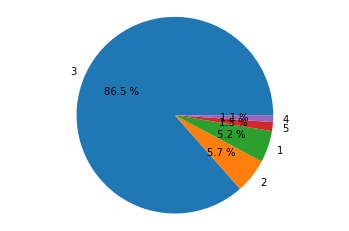

In [115]:
A = dfc2.Tópico.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

#####  Validación asignación de Tópicos

In [33]:
for index,score in sorted(lda[diccionario.doc2bow(dfc2.loc[2,'Opinion'])], key=lambda tup: -1*tup[1]):
    print("Score:{}\t Topic:{}".format(score,lda.print_topic(index,5)))

Score:0.4596456289291382	 Topic:0.064*"pag" + 0.046*"dej" + 0.044*"factur" + 0.038*"pued" + 0.036*"app"
Score:0.16236244142055511	 Topic:0.048*"consult" + 0.044*"registr" + 0.038*"necesit" + 0.037*"numer" + 0.035*"activ"
Score:0.147501602768898	 Topic:0.100*"servici" + 0.078*"mal" + 0.060*"internet" + 0.056*"lent" + 0.048*"señal"
Score:0.1186661571264267	 Topic:0.059*"funcion" + 0.047*"llam" + 0.032*"solucion" + 0.023*"sal" + 0.022*"telefon"
Score:0.1118241548538208	 Topic:0.047*"inform" + 0.027*"consum" + 0.026*"respuest" + 0.026*"registr_equip" + 0.021*"product"


In [34]:
bow_comentario = diccionario.doc2bow(dfc2.loc[2,'Opinion'])
distribucion_noticia = lda[bow_comentario]
dist_contrib = [topico[1] for topico in lda[bow_comentario]]
dist_contrib

[0.16236244, 0.1475016, 0.45964563, 0.111824155, 0.11866616]

####  fin validacion

###  zoom al topico_4  número 3

In [35]:
numeroTopicos=4
topicoZoom=4

In [36]:
## Quitar pag pactur
dfc2Zoom=dfc2.copy()
dfc2Zoom['contienePagFact']=dfc2Zoom['Opinion'].apply(lambda x: 1 if 'pag' in x else 0)
dfc2Zoom=dfc2Zoom[dfc2Zoom['contienePagFact']==0]
dfc2Zoom=dfc2Zoom[dfc2Zoom['Tópico']==topicoZoom]

In [37]:
# Repite el proceso de topicos

In [38]:
Lista_generalZoom=[]
for column in Qs:   
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc2Zoom["Tokens_"+column+"_T"].tolist()
        listAux = [x for x in listAux if x!= []]
        Lista_generalZoom = Lista_generalZoom+listAux

In [39]:
bigramZoom = gensim.models.Phrases(Lista_generalZoom, min_count=5, threshold=10) 
trigramZoom = gensim.models.Phrases(bigramZoom[Lista_generalZoom], threshold=10)
bigram_modZoom = gensim.models.phrases.Phraser(bigramZoom)
trigram_modZoom = gensim.models.phrases.Phraser(trigramZoom)
data_words_bigramsZoom = make_bigrams(Lista_generalZoom,bigram_modZoom)
diccionarioZoom = Dictionary(data_words_bigramsZoom)
diccionarioZoom.filter_extremes(no_below=2, no_above = 0.9)
corpusZoom = [diccionarioZoom.doc2bow(noticia) for noticia in data_words_bigramsZoom]

In [40]:
ldaZoom = LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [41]:
lda_display = pyLDAvis.gensim_models.prepare(ldaZoom, corpusZoom, diccionarioZoom, sort_topics=False)
pyLDAvis.display(lda_display)

In [42]:
dfc2Zoom['TópicoZoom'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2Zoom.index:
    bow_comentario = diccionarioZoom.doc2bow(dfc2Zoom.loc[i,'Opinion'])
    distribucion_noticia = ldaZoom[bow_comentario]
    dist_contrib = [topico[1] for topico in ldaZoom[bow_comentario]]
    dfc2Zoom.loc[i,'TópicoZoom']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx] 

In [43]:
dfc2Zoom.TópicoZoom.value_counts()

1    11
2    10
3     6
4     3
Name: TópicoZoom, dtype: int64

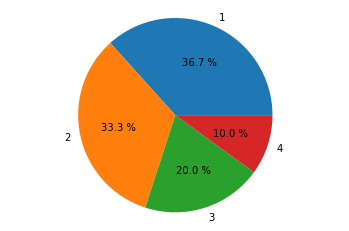

In [44]:
A = dfc2Zoom.TópicoZoom.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

In [45]:
impresionTopicosLimp(ldaZoom,15,20)

1  busc inform clar product client encontr benefici muestr señal quit opcion solucion dar requer encuentr 
2  inform product dan solicit adquir consult pued hbo obten tod escrib clarid necesit descarg nuev 
3  consum pqr ayud servici radic netflyx suspend bol detall envi llam activ internet mal acerc 
4  transferent encuentr quej coloc nadi resuelv com sol dto cupon ofrec mal internet consum activ 


In [46]:
#Guardar tabla de palabras

### Modelado de Topicos por Acción

In [47]:
len(dfc2)

2745

In [48]:
len(dfc)

7951

In [49]:
#dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
len(dfSent)

14609

In [50]:
len(dfSent[dfSent['Q2_NPS_GROUP']!='Promotor'])

7951

In [51]:
len(dfSent[dfSent['Q2_NPS_GROUP']!='Promotor'].fillna(''))

7951

In [52]:
numeroTopicos=4
topicoZoom=4

In [53]:
ZoomAccion=dfc2.copy()

In [54]:
ZoomAccion.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q19', 'Q2_NPS_GROUP', 'Q2',
       'Q3', 'Q4', 'Q9', 'Q10', 'Q11', 'Q12', 'Q15', 'Q26_1', 'Q22_1', 'Q18',
       'Q24_1', 'Q20', 'Nombre del cliente App', 'ID cuenta o Telefono App',
       'email App', 'Segmento App', 'Modulo App', 'Accion',
       'Q_DataPolicyViolations', 'Q15 - Parent Topics',
       'Q15 - Sentiment Polarity', 'Q15 - Sentiment Score', 'Q15 - Sentiment',
       'Q15 - Topic Sentiment Label', 'Q15 - Topic Sentiment Score',
       'Q15 - Topics', 'Q20 - Parent Topics', 'Q20 - Sentiment Polarity',
       'Q20 - Sentiment Score', 'Q20 - Sentiment',
       'Q20 - Topic Sentiment Label', 'Q20 - Topic Sentiment Score',
       'Q20 - Topics', 'Tokens_Q4',

In [55]:
acciones=ZoomAccion.Accion.unique()

Pre_Consulta_Saldos


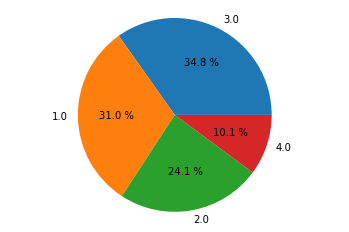

1  dat ingres dej cuent app ningun funcion actualiz consult pued si pag_factur consum fall sald permit siempr dificil pod lent 
2  pag recarg pud clar servici factur error hog realiz opcion tarjet pued llam paquet app dej asesor hac mes sal 
3  señal mal lent sald dat plan consum internet llam dias app paquet carg activ compr bien consult ver qued servici 
4  app numer registr pued line cambi demor siempr hac da cambi_nombr wifi pas quier opcion ok cos permit vez red 
Pre_Elegidos


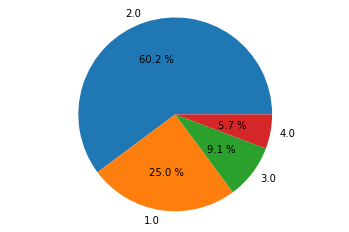

1  pud servici mal activ señal plan clar tampoc famili_amig tiend clar_vide famili visit usar problem product pesim baj conexion cumpl 
2  pag factur app hac ingres pued plan dat lent clar dej internet funcion realiz llam carg registr pod benefici dic 
3  activ numer famili_amig dej cambi inscrib aplic amig pued pud oper famili se grup clar_vide abre elej refer registr agreg_numer 
4  quier contact agreg movil consult famili factur grup form sub ala averigu eleg permit lent equip muestr agend_cit fij compart 
Pre_Detalle_Plan


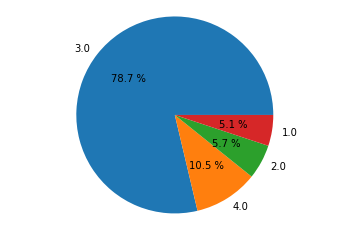

1  plan encontr encuentr busc recarg facil compr nadi lleg chat qued da_opcion descarg cambi_numer se adquir cancel_plan ahor clar_play com 
2  factur consult inform clar_hog pag asesor hbo mir ayud hbo_max respond dan netflix revis consum person much valor pqr muestr 
3  pag dej pued app ver clar ingres hac pud cuent dat aplic necesit dic aparec sirv pod lent funcion registr 
4  servici mal internet entrar llam pesim solucion señal cancel hog cambi_clav wifi telefon equip_financi atencion fall contest tecnic visit_tecnic conexion 
Pre_Paquetes-Recargas


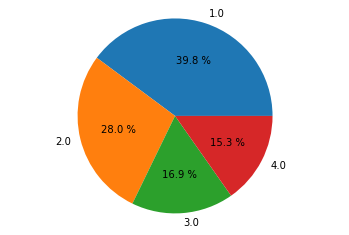

1  recarg hac pud mal realiz permit celul pued carg_factur cuent clar servici line internet pag compr_paquet clar_hog factur transaccion hog 
2  dej recarg pag lent pse realiz carg hac ingres ningun qued codig gust numer vec dat error dic paquet conect 
3  app opcion pag paquet pid carg sald tarjet mierd clar dar sirv much utiliz bloque aparec credit dias dat pud 
4  compr_paquet funcion hac app aplic dej recarg dat pod carg compr si much pag lent nunc plan qued pes cos 
Pre_Gestionar_Equipo


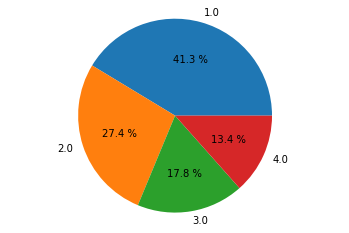

1  equip registr imei pud dej pag celul consult financi inform nuev dic necesit permit siempr respuest realiz hac pued dan 
2  señal mal lent internet clar sirv servici carg pesim dat app opcion demor fall solucion llam asesor hog respond problem 
3  pag funcion hac pued aparec dat celul total ingres consult compr bien realiz report sab valor cambi nunc moment mas 
4  pag_factur solucion pued dej factur compr si app hac ver entrar dan servici clar much dat problem pregunt celul sal 


In [56]:
modelosAccion={}
for accion in acciones:
    print(accion)
    Lista_generalZoom=[]
    ZoomAccionAux=ZoomAccion[ZoomAccion['Accion']==accion]
    for column in Qs:   
        if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
            listAux = ZoomAccionAux["Tokens_"+column+"_T"].tolist()
            listAux = [x for x in listAux if x!= []]
            Lista_generalZoom = Lista_generalZoom+listAux

    bigramZoom = gensim.models.Phrases(Lista_generalZoom, min_count=5, threshold=10) 
    trigramZoom = gensim.models.Phrases(bigramZoom[Lista_generalZoom], threshold=10)
    bigram_modZoom = gensim.models.phrases.Phraser(bigramZoom)
    trigram_modZoom = gensim.models.phrases.Phraser(trigramZoom)
    data_words_bigramsZoom = make_bigrams(Lista_generalZoom,bigram_modZoom)
    diccionarioZoom = Dictionary(data_words_bigramsZoom)
    diccionarioZoom.filter_extremes(no_below=2, no_above = 0.9)
    corpusZoom = [diccionarioZoom.doc2bow(noticia) for noticia in data_words_bigramsZoom]

    #ldaZoomAccion = LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, 
    #               num_topics=numeroTopicos, random_state=35, 
    #               chunksize=1000, iterations=200, passes=40, alpha='auto')
    modelosAccion[accion]=LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, num_topics=numeroTopicos, random_state=35, 
                   chunksize=1000, iterations=200, passes=40, alpha='auto')

    modelosAccion[accion+'dis']=pyLDAvis.gensim_models.prepare(modelosAccion[accion], corpusZoom, diccionarioZoom, sort_topics=False)
    
    ##dfc2Zoom['TópicoZoom'] = ""
    sumaTopicos = [0]*(numeroTopicos+1)
    for i in ZoomAccionAux.index:
        bow_comentario = diccionarioZoom.doc2bow(ZoomAccionAux.loc[i,'Opinion'])
        distribucion_noticia = modelosAccion[accion][bow_comentario]
        dist_contrib = [topico[1] for topico in modelosAccion[accion][bow_comentario]]
        ZoomAccionAux.loc[i,'TópicoZoomAccion']=dist_contrib.index(max(dist_contrib))+1

        # sumar pertenencias a los tópicos
        for idx, val in enumerate(dist_contrib):
            sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx] 

    ZoomAccionAux.TópicoZoomAccion.value_counts()
    A = ZoomAccionAux.TópicoZoomAccion.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.1f %%")
    plt.axis("equal")
    plt.show()

    impresionTopicosLimp(modelosAccion[accion],20,20)
    
    #acumular tabla resultados
    ZoomAccion['Top_Zoom_'+accion]=ZoomAccionAux['TópicoZoomAccion']

##  Información Modelos

In [57]:
pyLDAvis.display(modelosAccion['Pre_Detalle_Plandis'])

In [58]:
pyLDAvis.display(modelosAccion['Pre_Elegidosdis'])

In [59]:
pyLDAvis.display(modelosAccion['Pre_Consulta_Saldosdis'])

In [60]:
pyLDAvis.display(modelosAccion['Pre_Gestionar_Equipodis'])

In [61]:
pyLDAvis.display(modelosAccion['Pre_Paquetes-Recargasdis'])

######  fin Zoom

####  Construcción Tabla Final 

In [62]:
ZoomAccion

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion,Tópico,Top_Zoom_Pre_Consulta_Saldos,Top_Zoom_Pre_Elegidos,Top_Zoom_Pre_Detalle_Plan,Top_Zoom_Pre_Paquetes-Recargas,Top_Zoom_Pre_Gestionar_Equipo
2,2021-08-01 00:03:40,2021-08-01 00:06:10,0,191.156.38.37,100,150,1,2021-08-01 00:06:11.288,R_1EcfZSS3c60c0mV,,...,[],[],[],"[no, ...]",3,3.0,NaN,NaN,NaN,NaN
12,2021-08-01 03:41:59,2021-08-01 03:44:19,0,181.136.137.90,100,139,1,2021-08-01 03:44:19.375,R_AcJ6tmnGGBi4Kwp,,...,"[pued, hac, consult]","[dic, conexion, internet]",[],"[no, pued, hac, consult, me, dic, conexion, in...",3,3.0,NaN,NaN,NaN,NaN
29,2021-07-31 06:54:36,2021-07-31 06:57:13,0,191.102.110.114,35,156,0,2021-08-01 06:57:14.795,R_9oBYU3MBAdvzlGV,,...,[],"[mejor, inscripcion, eleg]",[],"[mejor, inscripcion, eleg]",3,NaN,4.0,NaN,NaN,NaN
43,2021-08-01 07:34:12,2021-08-01 07:35:44,0,181.63.156.46,100,91,1,2021-08-01 07:35:44.767,R_3F4h848vnFhBRzr,,...,[],[],[],[complet],3,3.0,NaN,NaN,NaN,NaN
45,2021-08-01 07:43:41,2021-08-01 07:45:04,0,191.156.43.177,100,83,1,2021-08-01 07:45:04.815,R_1DqhCkZ5Xr5XDpR,,...,[mal],[jhgccc],[],"[muy, mal, jhgccc]",3,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14583,2021-08-31 22:42:41,2021-08-31 22:45:27,0,191.156.156.197,100,165,1,2021-08-31 22:45:27.330,R_vczS9RyQafytENr,,...,"[q, sal, aplic, cambi, numer]","[cambi, nimer]",[],"[q, sal, aplic, cambi, numer, cambi, nimer]",3,NaN,NaN,3.0,NaN,NaN
14589,2021-08-30 22:55:51,2021-08-30 22:58:05,0,181.60.16.81,41,133,0,2021-08-31 22:58:06.873,R_2aXCJApAQi3rved,,...,[],"[administr, wifi]",[],"[com, administr, wifi]",3,NaN,NaN,3.0,NaN,NaN
14596,2021-08-31 23:14:27,2021-08-31 23:16:32,0,191.95.48.252,100,124,1,2021-08-31 23:16:32.361,R_21vzaanZGL0D3bl,,...,"[poc, opcion]",[],[],"[muy, poc, opcion, nad]",3,NaN,NaN,NaN,3.0,NaN
14605,2021-08-31 23:36:56,2021-08-31 23:41:48,0,181.51.33.29,100,291,1,2021-08-31 23:41:48.312,R_vPmzxQRYLqoFNkt,,...,"[dej, agreg, contact, famili, amig]","[agreg, contact, grup, famili]",[],"[no, dej, agreg, numer, grup, famil, no, dej, ...",1,NaN,2.0,NaN,NaN,NaN


In [63]:
len(df)

14609

In [64]:
len(dfSent)

14609

In [65]:
len(dfc2)

2745

In [66]:
len(dfc2Zoom)

30

In [67]:
TablaFinal=df.copy()
for column in Qs:    
    TablaFinal["Sent_"+column]=dfSent["Sent_"+column] 
TablaFinal['Opinion']=dfc2['Opinion']
TablaFinal['Topico']=dfc2['Tópico']
TablaFinal['TópicoZoom']=dfc2Zoom['TópicoZoom']

In [68]:
###  Agregar Información
for accion in acciones:
    TablaFinal['TópicoAccion_'+accion]=ZoomAccion['Top_Zoom_'+accion]

In [69]:
TablaFinal[TablaFinal['Accion']=="Pre_Detalle_Plan"]

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Sent_Q20,Opinion,Topico,TópicoZoom,TópicoAccion_Pre_Consulta_Saldos,TópicoAccion_Pre_Elegidos,TópicoAccion_Pre_Detalle_Plan,TópicoAccion_Pre_Paquetes-Recargas,TópicoAccion_Pre_Gestionar_Equipo
9,2021-08-01 02:53:19,2021-08-01 02:55:09,0,179.51.113.53,100,109,1,2021-08-01 02:55:09.479000,R_oY0xEScYtmBx0zL,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2021-08-01 03:28:35,2021-08-01 03:29:41,0,181.129.169.38,100,66,1,2021-08-01 03:29:41.999000,R_1zsIXjtnNp75eSZ,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2021-08-01 05:01:02,2021-08-01 05:02:48,0,190.143.48.121,100,106,1,2021-08-01 05:02:49.799000,R_2EovRbAF4mJZuvW,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2021-08-01 07:06:58,2021-08-01 07:09:07,0,191.156.180.65,100,128,1,2021-08-01 07:09:07.322000,R_2V3CgfegO6y79Ud,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2021-07-31 07:14:01,2021-07-31 07:14:36,0,191.109.92.209,0,34,0,2021-08-01 07:14:40.181000,R_2X5tbt8sycIIuAU,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14578,2021-08-31 22:24:48,2021-08-31 22:25:49,0,190.90.9.121,100,60,1,2021-08-31 22:25:49.577000,R_2E6NWpqZIi3hfaz,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14583,2021-08-31 22:42:41,2021-08-31 22:45:27,0,191.156.156.197,100,165,1,2021-08-31 22:45:27.330000,R_vczS9RyQafytENr,NaN,...,-0.6916568725552124,,"[q, sal, aplic, cambi, numer, cambi, nimer]",3,NaN,NaN,NaN,3.0,NaN,NaN
14589,2021-08-30 22:55:51,2021-08-30 22:58:05,0,181.60.16.81,41,133,0,2021-08-31 22:58:06.873000,R_2aXCJApAQi3rved,NaN,...,0.03347498436245333,,"[com, administr, wifi]",3,NaN,NaN,NaN,3.0,NaN,NaN
14606,2021-08-30 23:45:59,2021-08-30 23:46:46,0,181.142.161.28,41,47,0,2021-08-31 23:46:48.554000,R_3FKiKz66K1XYuT3,NaN,...,-0.14107212091566557,,"[compr, plan, postpag]",3,NaN,NaN,NaN,3.0,NaN,NaN


In [70]:
TablaFinal.to_csv('TablaFinalAgo.csv',index=False, sep=';', encoding="utf-8-sig")